In [35]:
%%writefile requirements.txt
tensorflow==2.17.0
keras==3.4.1

Overwriting requirements.txt


In [36]:
!pip install -r requirements.txt
!pip install keras-cv

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [37]:
import keras_cv
import numpy as np
import os
import tensorflow as tf
import keras as tfk      
from keras.layers import Input, Dense, Dropout, Lambda
from keras import layers as tfkl
from keras.utils import to_categorical
from collections import Counter
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import sklearn as scikit_learn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

seed = 42

print(f"Tensorflow version -> {tf.__version__}")
print(f"Keras version -> {tfk.__version__}")

Tensorflow version -> 2.17.0
Keras version -> 3.4.1


# Help Functions

In [38]:
#Given a labels dataset, returns a dictionary with the class sample counts
def count_classes(labels):
 
    # Se le etichette sono codificate one-hot, convertili a indici
    if isinstance(labels, np.ndarray) and len(labels.shape) > 1:
        labels = np.argmax(labels, axis=1)
    
    # Usa numpy per contare le occorrenze di ogni classe
    unique_classes, counts = np.unique(labels, return_counts=True)
    
    # Crea un dizionario per restituire il conteggio
    class_counts = {cls: count for cls, count in zip(unique_classes, counts)}
    return class_counts

def plot_confusion_matrix(model, X_test, y_test):
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    if y_test.ndim > 1:
        y_test = np.argmax(y_test, axis=1)

    cm = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(len(cm)))
    disp.plot(cmap='viridis', xticks_rotation='vertical')
    plt.title('Confusion Matrix')
    plt.show()


# Load and duplicate Data

In [39]:
#This time we work on Kagge
#Load the dataset from the .npz file and take "images" and "labels"
data = np.load('/kaggle/input/dataset/training_set_without_outlier.npz') # or 'datsetWithout.npz'

images = data['images']
labels = data['labels'] 
print(f'Images shape: {images.shape}')
print(f'Labels shape: {labels.shape}')

#show the amout of samples for each class
classes = count_classes(labels.flatten())
print(classes)

## We duplicate the first 800 images for the class 0,2,4,5
quantity = 800
class_to_duplicate = [0,2,4,5]
for i in class_to_duplicate:
    class_N_indices = np.where(labels.flatten() == i)[0]
    images_N = images[class_N_indices][:quantity]
    labels_N = labels[class_N_indices][:quantity]
    images = np.concatenate([images, images_N], axis=0)
    labels = np.concatenate([labels, labels_N], axis=0)

#show the amout of samples for each class after the duplication
classes = count_classes(labels.flatten())
print(classes)

#Initial shuffle of the data
indices = np.random.permutation(len(images))
shuffled_images = images[indices]
shuffled_labels = labels[indices]

#Free some memory
del data
del images
del labels

Images shape: (11959, 96, 96, 3)
Labels shape: (11959, 1)
{0: 852, 1: 2181, 2: 1085, 3: 2026, 4: 849, 5: 993, 6: 2330, 7: 1643}
{0: 1652, 1: 2181, 2: 1885, 3: 2026, 4: 1649, 5: 1793, 6: 2330, 7: 1643}


In [40]:
#Normalization of images and categorical format for labels
normalized_images = shuffled_images / 255.0
categorical_labels = to_categorical(shuffled_labels).astype('float32')

#Free some memory
del shuffled_images 
del shuffled_labels

In [41]:
#Split data into Training set and Validation set
X_train, X_val, y_train, y_val = train_test_split(normalized_images, categorical_labels, test_size=0.2, stratify=categorical_labels)
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(12127, 96, 96, 3)
(3032, 96, 96, 3)
(12127, 8)
(3032, 8)


# Augmentation

In [42]:
# Heavy augmentation for validation set
data_augmentation_val = tfk.Sequential(
[
    keras_cv.layers.RandomAugmentationPipeline(
    layers=[
        keras_cv.layers.RandomTranslation(height_factor=0.5, width_factor=0.5, seed=seed),
        keras_cv.layers.RandomTranslation(height_factor=0.5, width_factor=0.5, seed=seed),
        keras_cv.layers.RandomContrast(factor=0.8, value_range=(0.0, 1.0), seed=seed),
        keras_cv.layers.RandomHue(factor=(0.8,1.0), value_range=(0.0, 1.0), seed=seed),
        keras_cv.layers.RandomSharpness(factor = 1, value_range=(0.0, 1.0), seed=seed),
        keras_cv.layers.RandomColorDegeneration(factor = 1, seed=seed),
        keras_cv.layers.ChannelShuffle(groups=3, seed=seed),
        keras_cv.layers.RandomChannelShift(factor=0.8, value_range=(0.0, 1.0), channels=3, seed=seed),
        keras_cv.layers.Solarization(value_range = (0.0, 1.0), seed=seed),
        keras_cv.layers.RandomBrightness(factor=0.3, value_range=(0.0, 1.0), seed=seed),
        keras_cv.layers.GridMask(ratio_factor=(0, 0.4), rotation_factor=0.2, fill_mode="constant", fill_value=0.0, seed=seed)
    ],
    seed=seed,
    augmentations_per_image=3
)
])


# Usual augmentation for training set
data_augmentation_tr = tfk.Sequential(
[
    keras_cv.layers.RandAugment(
        value_range=(0.0, 1.0),
        augmentations_per_image=4,
        magnitude_stddev=0.4, 
        rate=0.5
    )
])


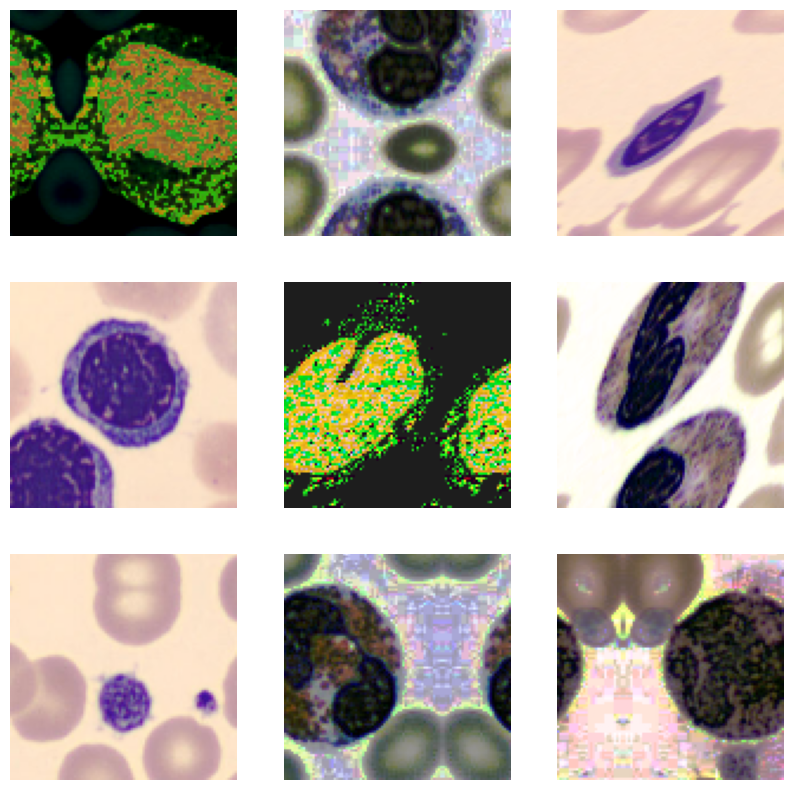

In [43]:
#Try to augment a portion of the X_train images
image_portion = X_train[:10]
image_portion = data_augmentation_tr(image_portion)

#Plot the augmentations
plt.figure(figsize=(10, 10))
for i in range(9):
   plt.subplot(3, 3, i + 1)
   plt.imshow(image_portion[i]) 
   plt.axis("off")
plt.show()

In [44]:
#Convert the data into a more suitable format that speeds up the augmentation a lot
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(512)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(512)

In [45]:
#wrapper fucntion for the augmentation of training set
def augment_images_tr(image, label):
    image = data_augmentation_tr(image)  # Apply data augmentation to the image
    return image, label  # Return the augmented image and the unchanged label

#wrapper fucntion for the augmentation of validation set
def augment_images_val(image, label):
    image = data_augmentation_val(image)  # Apply data augmentation to the image
    return image, label  # Return the augmented image and the unchanged label

# Apply the mapping to both Train and Validation sets
train_dataset = train_dataset.map(augment_images_tr, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

val_dataset = val_dataset.map(augment_images_val, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

In [46]:
# Reconvert the Training and Validation set into numpy arrays
X_train, y_train = [], []
for batch in train_dataset:
    images = batch[0].numpy()
    labels = batch[1].numpy()
    X_train.append(images)
    y_train.append(labels)
X_train = np.concatenate(X_train, axis=0)
y_train = np.concatenate(y_train, axis=0)

del train_dataset

# Convert validation dataset to numpy arrays
X_val, y_val = [], []
for batch in val_dataset:
    images = batch[0].numpy()
    labels = batch[1].numpy()
    X_val.append(images)
    y_val.append(labels)
X_val = np.concatenate(X_val, axis=0)
y_val = np.concatenate(y_val, axis=0)

del val_dataset

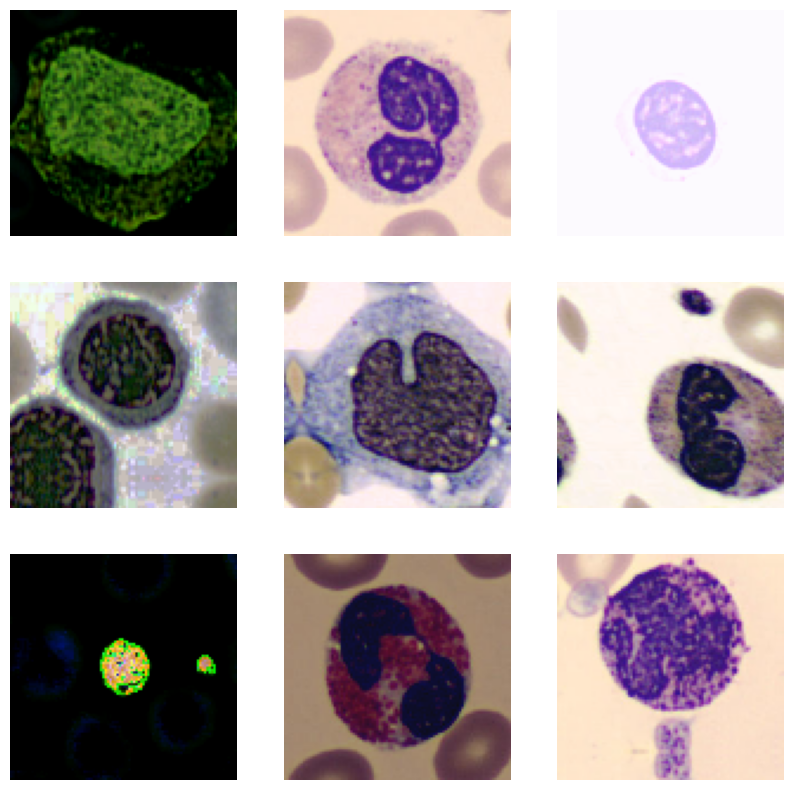

In [47]:
#Debug the augmentation process
image_portion = X_train[:10]

# Shows the 9 images of X_train after augmentation
plt.figure(figsize=(10, 10))
for i in range(9):
   plt.subplot(3, 3, i + 1)
   plt.imshow(image_portion[i]) 
   plt.axis("off")
plt.show()

# Transfer Learning from MobileNetV3Small 

In [48]:
net_name = "MobileNetV3Small"

In [49]:
input_shape = (96, 96, 3)
output_shape = 8
learning_rate = 0.005
batch_size = 64
epochs = 1000


# Initialise MobileNetV3Small model with pretrained weights
ext_net = tfk.applications.MobileNetV3Small(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet',
    pooling='avg',
    include_preprocessing=True
)

# Display a summary of the model architecture
ext_net.summary(expand_nested=True)

/opt/conda/lib/python3.10/site-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "MobileNetV3Small"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 96, 96, 3) │          0 │ input_layer_7[0]… │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 48, 48,    │        432 │ rescaling_2[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 48, 48,    │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 48, 48,    │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 49, 49,    │          0 │ activation_1[0][… │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 24, 24,    │        144 │ expanded_conv_de… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 24, 24,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 24, 24,    │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │          0 │ re_lu[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │        136 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │          0 │ expanded_conv_sq… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │        144 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 1, 16)  │          0 │ expanded_conv_sq… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 1, 1, 16)  │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 1, 1, 16)  │          0 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 24, 24,    │          0 │ re_lu[0][0],      │
│ (Multiply)          │ 16)               │            │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 24, 24,    │        256 │ expanded_conv_sq

 Total params: 939,120 (3.58 MB)

 Trainable params: 927,008 (3.54 MB)

 Non-trainable params: 12,112 (47.31 KB)

In [50]:
# Freeze all layers in MobileNetV3Small , first we train only the classification head
ext_net.trainable = False

inputs = tfk.Input(shape=input_shape, name='input_layer')

x = ext_net(inputs)
x = tfkl.Dropout(0.3, name='dropout')(x)
x = tfkl.Dense(256, name='dense1')(x)
x = tfkl.BatchNormalization()(x)
x = tfkl.Activation("relu")(x)

x = tfkl.Dropout(0.5, name='dropout1')(x)
outputs = tfkl.Dense(output_shape, activation='softmax', name='dense2')(x)

tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

tl_model.summary(expand_nested=True)

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Small (Functional)   │ (None, 576)            │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ input_layer_7 (InputLayer) │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ rescaling_2 (Rescaling)    │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv (Conv2D)              │ (None, 48, 48, 16)     │           432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv_bn                    │ (None, 48, 48, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ activation_1 (Activation)  │ (None, 48, 48, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 49, 49, 16)     │             0 │
│ expanded_conv_depthwise_pad     │                        │               │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ expanded_conv_depthwise    │ (None, 24, 24, 16)     │           144 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ expanded_conv_depthwise_bn │ (None, 24, 24, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ re_lu (ReLU)               │ (None, 24, 24, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 1, 1, 16)       │             0 │
│ expanded_conv_squeeze_excite_a… │                        │               │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 1, 1, 8)        │           136 │
│ expanded_conv_squeeze_excite_c… │                        │               │
│ (Conv2D)                        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 1, 1, 8)        │             0 │
│ expanded_conv_squeeze_excite_r… │                        │               │
│ (ReLU)                          │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 1, 1, 16)       │           144 │
│ expanded_conv_squeeze_excite_c… │                        │               │
│ (Conv2D)                        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ re_lu_1 (ReLU)             │ (None, 1, 1, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 24, 24, 16)     │             0 │
│ expanded_conv_squeeze_excite_m… │                        │               │
│ (Multiply)                      │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,089,912 (4.16 MB)

 Trainable params: 150,280 (587.03 KB)

 Non-trainable params: 939,632 (3.58 MB)

# Early Stopping

In [51]:
# Define the patience value for early stopping
patience = 40

# Create an EarlyStopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

# Store the callback in a list
callbacks = [early_stopping]

# Train classification head

In [52]:
history = tl_model.fit(
    x=X_train*255,
    y=y_train,
    batch_size = batch_size,
    epochs=epochs,
    validation_data=(X_val*255, y_val),
    callbacks=callbacks
).history

Epoch 1/1000
190/190 ━━━━━━━━━━━━━━━━━━━━ 25s 75ms/step - accuracy: 0.3881 - loss: 1.7557 - val_accuracy: 0.5327 - val_loss: 1.3639
Epoch 2/1000
190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6091 - loss: 1.0880 - val_accuracy: 0.5412 - val_loss: 1.3602
Epoch 3/1000
190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6379 - loss: 0.9988 - val_accuracy: 0.5607 - val_loss: 1.3150
Epoch 4/1000
190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6540 - loss: 0.9497 - val_accuracy: 0.5686 - val_loss: 1.2961
Epoch 5/1000
190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6740 - loss: 0.9062 - val_accuracy: 0.5801 - val_loss: 1.2640
Epoch 6/1000
190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6773 - loss: 0.8869 - val_accuracy: 0.5749 - val_loss: 1.2996
Epoch 7/1000
190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6763 - loss: 0.8732 - val_accuracy: 0.5759 - val_loss: 1.2556
Epoch 8/1000
190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6930 - loss: 

In [53]:
# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

Final validation accuracy: 61.91%


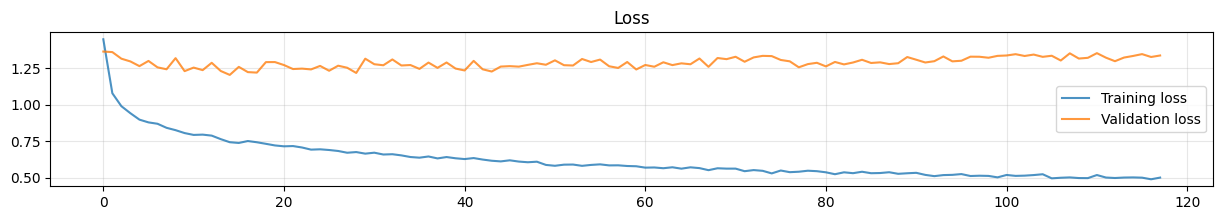

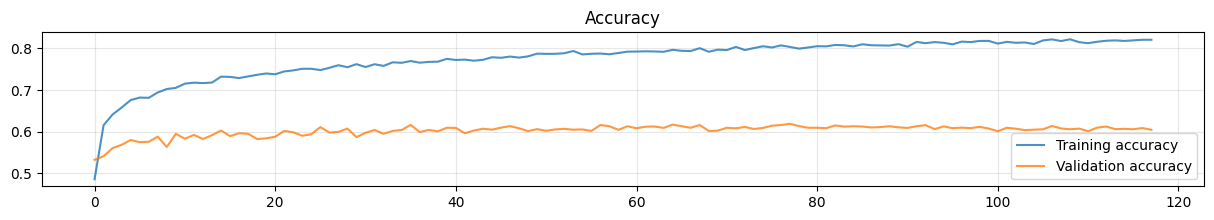

In [54]:
# Plot training and validation loss
plt.figure(figsize=(15, 2))
plt.plot(history['loss'], label='Training loss', alpha=.8)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8)
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


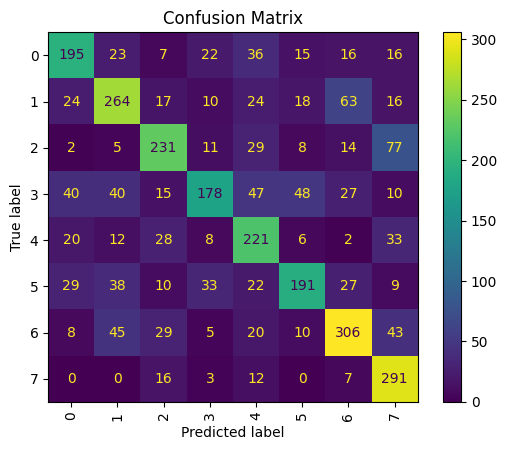

In [57]:
#Print confusion matrix on the validation set
plot_confusion_matrix(tl_model, X_val*255, y_val)

In [58]:
#Save the weight of the head
tl_model.save('weights_head.keras')
del tl_model

# Define Fine Tuning network

In [59]:
ft_model = tfk.models.load_model('weights_head.keras')
# Set the MobileNetV3Small  model layers as trainable
ft_model.get_layer(net_name).trainable = True

# Set all MobileNetV3Small layers as non-trainable
for layer in ft_model.get_layer(net_name).layers:
    layer.trainable = False

# Enable training only for Conv2D and DepthwiseConv2D layers
for i, layer in enumerate(ft_model.get_layer(net_name).layers):
    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.DepthwiseConv2D):
        layer.trainable = True
        print(i, layer.name, type(layer).__name__, layer.trainable)

2 conv Conv2D True
6 expanded_conv_depthwise DepthwiseConv2D True
10 expanded_conv_squeeze_excite_conv Conv2D True
12 expanded_conv_squeeze_excite_conv_1 Conv2D True
15 expanded_conv_project Conv2D True
17 expanded_conv_1_expand Conv2D True
21 expanded_conv_1_depthwise DepthwiseConv2D True
24 expanded_conv_1_project Conv2D True
26 expanded_conv_2_expand Conv2D True
29 expanded_conv_2_depthwise DepthwiseConv2D True
32 expanded_conv_2_project Conv2D True
35 expanded_conv_3_expand Conv2D True
39 expanded_conv_3_depthwise DepthwiseConv2D True
43 expanded_conv_3_squeeze_excite_conv Conv2D True
45 expanded_conv_3_squeeze_excite_conv_1 Conv2D True
48 expanded_conv_3_project Conv2D True
50 expanded_conv_4_expand Conv2D True
53 expanded_conv_4_depthwise DepthwiseConv2D True
57 expanded_conv_4_squeeze_excite_conv Conv2D True
59 expanded_conv_4_squeeze_excite_conv_1 Conv2D True
62 expanded_conv_4_project Conv2D True
65 expanded_conv_5_expand Conv2D True
68 expanded_conv_5_depthwise DepthwiseConv2

In [60]:
# Set the number of layers to freeze
N = 15 #We freeze only the first initial layers

# Set the first N layers as non-trainable
for i, layer in enumerate(ft_model.get_layer(net_name).layers[:N]):
    layer.trainable = False

# Print layer indices, names, and trainability status
for i, layer in enumerate(ft_model.get_layer(net_name).layers):
    print(i, layer.name, layer.trainable)

# Display a summary of the model architecture
ft_model.summary(expand_nested=True)


0 input_layer_7 False
1 rescaling_2 False
2 conv False
3 conv_bn False
4 activation_1 False
5 expanded_conv_depthwise_pad False
6 expanded_conv_depthwise False
7 expanded_conv_depthwise_bn False
8 re_lu False
9 expanded_conv_squeeze_excite_avg_pool False
10 expanded_conv_squeeze_excite_conv False
11 expanded_conv_squeeze_excite_relu False
12 expanded_conv_squeeze_excite_conv_1 False
13 re_lu_1 False
14 expanded_conv_squeeze_excite_mul False
15 expanded_conv_project True
16 expanded_conv_project_bn False
17 expanded_conv_1_expand True
18 expanded_conv_1_expand_bn False
19 re_lu_2 False
20 expanded_conv_1_depthwise_pad False
21 expanded_conv_1_depthwise True
22 expanded_conv_1_depthwise_bn False
23 re_lu_3 False
24 expanded_conv_1_project True
25 expanded_conv_1_project_bn False
26 expanded_conv_2_expand True
27 expanded_conv_2_expand_bn False
28 re_lu_4 False
29 expanded_conv_2_depthwise True
30 expanded_conv_2_depthwise_bn False
31 re_lu_5 False
32 expanded_conv_2_project True
33 expan

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Small (Functional)   │ (None, 576)            │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ input_layer_7 (InputLayer) │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ rescaling_2 (Rescaling)    │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv (Conv2D)              │ (None, 48, 48, 16)     │           432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv_bn                    │ (None, 48, 48, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ activation_1 (Activation)  │ (None, 48, 48, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 49, 49, 16)     │             0 │
│ expanded_conv_depthwise_pad     │                        │               │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ expanded_conv_depthwise    │ (None, 24, 24, 16)     │           144 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ expanded_conv_depthwise_bn │ (None, 24, 24, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ re_lu (ReLU)               │ (None, 24, 24, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 1, 1, 16)       │             0 │
│ expanded_conv_squeeze_excite_a… │                        │               │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 1, 1, 8)        │           136 │
│ expanded_conv_squeeze_excite_c… │                        │               │
│ (Conv2D)                        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 1, 1, 8)        │             0 │
│ expanded_conv_squeeze_excite_r… │                        │               │
│ (ReLU)                          │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 1, 1, 16)       │           144 │
│ expanded_conv_squeeze_excite_c… │                        │               │
│ (Conv2D)                        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ re_lu_1 (ReLU)             │ (None, 1, 1, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 24, 24, 16)     │             0 │
│ expanded_conv_squeeze_excite_m… │                        │               │
│ (Multiply)                      │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,390,474 (5.30 MB)

 Trainable params: 1,064,320 (4.06 MB)

 Non-trainable params: 25,592 (99.97 KB)

 Optimizer params: 300,562 (1.15 MB)

In [61]:
# Compile the model
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics=['accuracy'])

# Early Stopping

In [62]:
# Define the patience value for early stopping
patience = 15 

# Create an EarlyStopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

# Store the callback in a list
callbacks = [early_stopping]

# Train Fine Tuning Network

In [63]:
# Fine-tune the model
ft_history = ft_model.fit(
    x=X_train*255,
    y=y_train,
    batch_size = batch_size,
    epochs=130,
    validation_data=(X_val*255, y_val),
    callbacks=callbacks
).history


Epoch 1/130


E0000 00:00:1732043514.678948     105 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1732043514.862923     105 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


188/190 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8135 - loss: 0.5174

E0000 00:00:1732043529.111850     106 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1732043529.295378     106 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


190/190 ━━━━━━━━━━━━━━━━━━━━ 45s 121ms/step - accuracy: 0.8136 - loss: 0.5170 - val_accuracy: 0.6319 - val_loss: 1.2106
Epoch 2/130
190/190 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.8584 - loss: 0.4085 - val_accuracy: 0.6507 - val_loss: 1.1468
Epoch 3/130
190/190 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.8726 - loss: 0.3632 - val_accuracy: 0.6675 - val_loss: 1.0757
Epoch 4/130
190/190 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.8922 - loss: 0.3141 - val_accuracy: 0.6712 - val_loss: 1.0833
Epoch 5/130
190/190 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9022 - loss: 0.2806 - val_accuracy: 0.6715 - val_loss: 1.0715
Epoch 6/130
190/190 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9070 - loss: 0.2641 - val_accuracy: 0.6797 - val_loss: 1.0666
Epoch 7/130
190/190 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9241 - loss: 0.2290 - val_accuracy: 0.6956 - val_loss: 1.0156
Epoch 8/130
190/190 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9333 - loss: 0.1959 - val_accura

In [64]:
# Calculate and print the final validation accuracy
final_val_accuracy = round(max(ft_history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

Final validation accuracy: 77.18%


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step


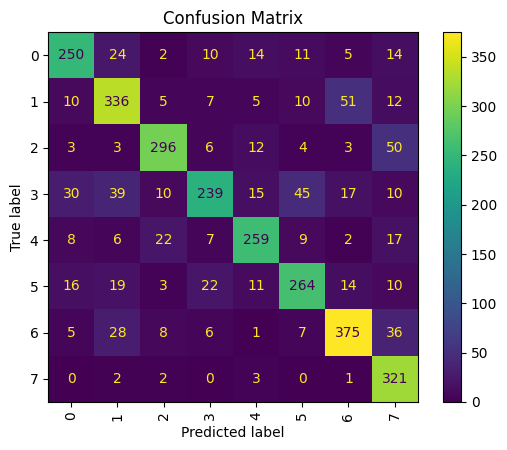

In [65]:
#Print confusion matrix on the validation set
plot_confusion_matrix(ft_model, X_val*255, y_val)

In [66]:
#Save the weights of the whole network
ft_model.save('weights.keras')

# Submission

In [69]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model('weights.keras')

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must not be one-hot
        encoded.

        We do not need /255 as the network has a preprocessing layer inside.
        """

        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
           preds = np.argmax(preds, axis=1)
        return preds



Overwriting model.py


In [70]:
from datetime import datetime
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Add files to the zip command if needed
!zip {filename} model.py weights.keras

  adding: model.py (deflated 53%)
  adding: weights.keras (deflated 11%)
